# 00. Homework description

For this assignment, your task is to develop the [FastPitch](https://arxiv.org/abs/2006.06873) synthesis model, train it, and generate several audio samples.

The training and data processing code has already been provided for you. The training will be conducted on the LJspeech dataset.

The total score for the homework is **10 points**, distributed as follows:
- 1 point for visualizing the input data
- 8 points for writing the model code and running training
- 1 point for pitch and duration manipulations during inference

The homework submission **should include**:
- Completed notebook
- Attached WER and loss graphs from TensorBoard
- 1 audio file - the result of a regular model inference
- 4 additional audio files: you are encouraged to experiment with adjusting phoneme durations and pitch slightly and listen to the results.

# 01. Preparation steps

In [1]:
device = "cuda"
gpu_avaiable = "0"      # Run nvidia-smi to find free GPU

In [2]:
# Path to the the current week's source code, e.g. /home/user/speech_course/week_08_tts_am_vocoders
path_to_sources = "/home/jovyan/askutsakov/research/hw/speech_course/week_08_tts_am_vocoders"

In [3]:
# If running in colab

# clone the repository:
# git clone https://github.com/yandexdataschool/speech_course.git
# !pip install -r speech_course/week_08_tts_am_vocoders/requirements.txt

### Dataset

We will work with [LJSpeech](https://keithito.com/LJ-Speech-Dataset/) -- a single-speaker dataset with 24 hours of speech.

The data we will use contains pre-computed [MFA-alignments](https://montreal-forced-aligner.readthedocs.io/en/latest/user_guide/workflows/alignment.html) alongside with the original wavs and texts. If you are interested in the process of extracting such alignments, please refer to this [tutorial](https://colab.research.google.com/gist/NTT123/12264d15afad861cb897f7a20a01762e/mfa-ljspeech.ipynb).

Download the dataset with precomputed alignments.

In [4]:
import requests
from urllib.parse import urlencode
from io import BytesIO
from zipfile import ZipFile

# base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# public_key = 'https://disk.yandex.ru/d/PpgePfWcQTAbug'

# final_url = base_url + urlencode(dict(public_key=public_key))
# response = requests.get(final_url)
# download_url = response.json()['href']
# response = requests.get(download_url)

path_to_dataset = 'data/ljspeech'    # Choose any appropriate local path

# zipfile = ZipFile(BytesIO(response.content))
# zipfile.extractall(path=path_to_dataset)

### Hi-Fi GAN checkpoint


Download a pretrained Hi-Fi GAN checkpoint (to generate audio from the predicted mel-spectrograms).

In [5]:
# !wget --content-disposition https://api.ngc.nvidia.com/v2/models/nvidia/dle/hifigan__pyt_ckpt_ds-ljs22khz/versions/21.08.0_amp/zip -O hifigan_ckpt.zip
# !unzip hifigan_ckpt.zip
# !rm hifigan_ckpt.zip

In [6]:
path_to_hfg_ckpt = "hifigan_gen_checkpoint_6500.pt" 

### Imports

In [7]:
import sys
import os
import json
import dataclasses
import torch
import subprocess as sp
import matplotlib.pylab as plt
import soundfile as sf

from g2p_en import G2p
import IPython.display as Ipd

In [8]:
sys.path.append(path_to_sources)

# 02. See a data sample (1 point)

In [13]:
# ! pip install "setuptools<58.0.0"
# ! pip install parselmouth

In [14]:
# ! pip install -r ../requirements.txt

In [11]:
from sources.fastpitch.hparams import HParamsFastpitch
from sources.fastpitch.data import prepare_loaders

The mfa alignment provides phonemes and their durations, which we will need during training:

In [12]:
with open(os.path.join(path_to_dataset, 'mfa_aligned', 'LJ001-0001.json')) as f:
    utterance = json.load(f)

utterance

{'start': 0,
 'end': 9.655062,
 'tiers': {'words': {'type': 'interval',
   'entries': [[0.0, 0.69, 'printing'],
    [0.69, 0.82, '<eps>'],
    [0.82, 1.01, 'in'],
    [1.01, 1.15, 'the'],
    [1.15, 1.45, 'only'],
    [1.45, 1.97, 'sense'],
    [1.97, 2.14, 'with'],
    [2.14, 2.39, 'which'],
    [2.39, 2.54, 'we'],
    [2.54, 2.71, 'are'],
    [2.71, 2.89, 'at'],
    [2.89, 3.28, 'present'],
    [3.28, 4.0, 'concerned'],
    [4.0, 4.41, '<eps>'],
    [4.41, 5.01, 'differs'],
    [5.01, 5.04, '<eps>'],
    [5.04, 5.28, 'from'],
    [5.28, 5.65, 'most'],
    [5.65, 5.82, 'if'],
    [5.82, 6.1, 'not'],
    [6.1, 6.29, 'from'],
    [6.29, 6.63, 'all'],
    [6.63, 6.78, 'the'],
    [6.78, 7.09, 'arts'],
    [7.09, 7.22, 'and'],
    [7.22, 7.8, 'crafts'],
    [7.8, 8.45, 'represented'],
    [8.45, 8.66, 'in'],
    [8.66, 8.79, 'the'],
    [8.79, 9.6, 'exhibition'],
    [9.6, 9.655062, '<eps>']]},
  'phones': {'type': 'interval',
   'entries': [[0.0, 0.04, 'P'],
    [0.04, 0.07, 'R'],
    [0

Phoneme `sil` here denotes pause -- a period of silence between spoken phonemes. The phonemes are from [ARPA](https://en.wikipedia.org/wiki/ARPABET) alphabet.

In [13]:
hparams = HParamsFastpitch()
train_loader, val_loader = prepare_loaders(path_to_dataset, hparams)

In [14]:
train_iter = iter(train_loader)
batch = next(train_iter)

In [15]:
list(dataclasses.asdict(batch).keys())

['texts',
 'text_lengths',
 'mels',
 'mel_lengths',
 'pitches',
 'durations',
 'paces']

In [16]:
batch.mels.shape

torch.Size([10, 80, 852])

In [17]:
batch.pitches.shape

torch.Size([10, 118])

In [18]:
batch.durations.shape

torch.Size([10, 118])

## Task

**(0.5 points)** Draw a combined image showing both the mel-spectrogram and pitch for a sample from the batch. Use durations to ensure proper alignment of their shapes in the image.  
**(0.5 points)** Include phoneme labels near the time axis on the image from the previous step. (like in Figure 3 in the [paper](https://arxiv.org/pdf/2006.06873.pdf)). You may find the code from the seminar helpful.

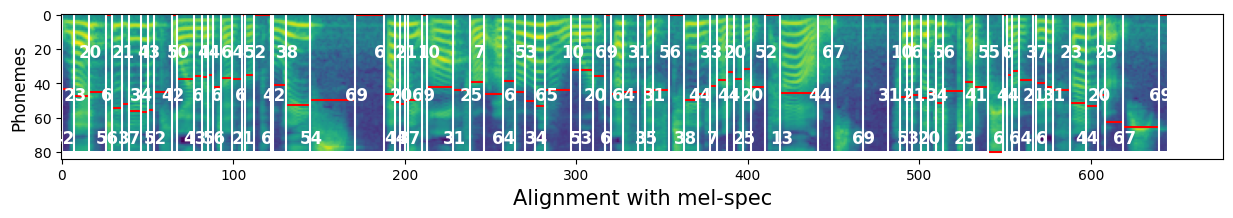

In [120]:
import numpy as np
import torch.nn.functional as F

def unnorm_pitch(pitches):
    mask = pitches == 0.0
    pitches = pitches * 62.51305 + 215.42230
    pitches[mask] = 0.
    mel_pitches = 2595.0 * torch.log10(1.0 + pitches / 700.0)
    # TODO: convert to filterbanks ??
    return (mel_pitches - mel_pitches.min()) / (mel_pitches.max() - mel_pitches.min()) * 80

def plot_segments(mel, durations, symbols, pitches, title=None):
    plt.gcf().set_size_inches(15, 10)
    plt.imshow(mel)
    plt.ylabel('Phonemes', fontsize=12)
    plt.xlabel('Alignment with mel-spec', fontsize=15)

    durations_cs = F.pad(durations.cumsum(-1), (1, 0))
    pitches = unnorm_pitch(pitches)

    for i, s in enumerate(durations_cs[:-1]):
        text_size = 12
        plt.text(
            s - text_size // 2,
            75 - 25 * (i % 3),
            symbols[i].item(),
            fontsize=text_size,
            weight='bold',
            color='w',
        )
        plt.hlines(
            pitches[i],
            durations_cs[i],
            durations_cs[i + 1],
            color='red',
        )

    for s in durations_cs:
        plt.axvline(x=s, c='white')

    plt.show()


sample_idx = 1
plot_segments(
    batch.mels[sample_idx][:, :batch.mel_lengths[sample_idx]],
    batch.durations[sample_idx][:batch.text_lengths[sample_idx]],
    batch.texts[sample_idx][:batch.text_lengths[sample_idx]],
    batch.pitches[sample_idx][:batch.text_lengths[sample_idx]],
)

# 03. Implement FastPitch model (9 points)

Please implement the FastPitch model in the cell provided below. Running this cell will overwrite the model file in the repository. 
- Run training (see next cells)
- Run inference (see next cells)
- When submitting the homework, please include
   - the Word Error Rate (WER) and loss curves obtained from TensorBoard as attachments,
   - the generated audio (see inference cells). If attaching an archive, use the name: `prediction.wav`

By the end of training, the loss should reach approximately 0.69, and WER should be close to zero (around 0.006). The training process will take about 30 minutes (3,000 batches).

**Important:** By the end of the training, the generated audio sample must be clear in terms of speech (WER close to 0) and maintain audio quality comparable to the original recordings (as logged in TensorBoard). **If these conditions are not met, the entire section will receive zero points**, regardless of how closely the model code resembles working code. Here is an example of how an audio from a well-trained model may sound:

In [121]:
audio, sr = sf.read('prediction_example.wav')
Ipd.display(Ipd.Audio(audio, rate=sr))

In [162]:
%%writefile {path_to_sources}/sources/fastpitch/model.py

import torch
from torch import nn as nn

from sources.fastpitch.common.layers import TemporalPredictor
from sources.fastpitch.common.utils import DeviceGetterMixin
from sources.fastpitch.common.utils import regulate_len
from sources.fastpitch.data import FastPitchBatch, SymbolsSet
from sources.fastpitch.hparams import HParamsFastpitch
from sources.fastpitch.common.transformer import FFTransformer


class FastPitch(nn.Module, DeviceGetterMixin):
    def __init__(self, hparams: HParamsFastpitch):
        super().__init__()
        self.hparams = hparams
        n_symbols = len(SymbolsSet().symbols_to_id)

        self.symbol_emb = nn.Embedding(n_symbols, hparams.symbols_embedding_dim)

        self.encoder = FFTransformer(
            n_layer=hparams.in_fft_n_layers,
            n_head=hparams.in_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.in_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.in_fft_conv1d_kernel_size,
            dropout=hparams.p_in_fft_dropout,
            dropatt=hparams.p_in_fft_dropatt,
            dropemb=hparams.p_in_fft_dropemb
        )

        self.duration_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.dur_predictor_filter_size,
            kernel_size=hparams.dur_predictor_kernel_size,
            dropout=hparams.p_dur_predictor_dropout,
            n_layers=hparams.dur_predictor_n_layers
        )

        self.pitch_predictor = TemporalPredictor(
            input_size=hparams.symbols_embedding_dim,
            filter_size=hparams.pitch_predictor_filter_size,
            kernel_size=hparams.pitch_predictor_kernel_size,
            dropout=hparams.p_pitch_predictor_dropout,
            n_layers=hparams.pitch_predictor_n_layers
        )

        self.pitch_emb = nn.Conv1d(1, hparams.symbols_embedding_dim, kernel_size=3, padding=1)

        self.decoder = FFTransformer(
            n_layer=hparams.out_fft_n_layers,
            n_head=hparams.out_fft_n_heads,
            d_model=hparams.symbols_embedding_dim,
            d_head=hparams.out_fft_d_head,
            d_inner=4 * hparams.symbols_embedding_dim,
            kernel_size=hparams.out_fft_conv1d_kernel_size,
            dropout=hparams.p_out_fft_dropout,
            dropatt=hparams.p_out_fft_dropatt,
            dropemb=hparams.p_out_fft_dropemb
        )

        self.proj = nn.Linear(hparams.symbols_embedding_dim, hparams.n_mel_channels, bias=True)

    def get_encoder_out(self, batch: FastPitchBatch):
        '''
        Return: 
        enc_out: 
            Output of the first series of FFT blocks (before adding pitch embedding)
            shape: (batch, len(text), symbols_embedding_dim)
        enc_mask:
            Boolean padding mask for the input text sequences
            shape: (batch, len(text), 1)
        '''
        emb_texts = self.symbol_emb(batch.texts)
        return self.encoder(emb_texts, batch.text_lengths)

    def forward(self, batch: FastPitchBatch, use_gt_durations=True, use_gt_pitch=True, max_duration=75):
        '''
        Flags `use_gt_durations` and `use_gt_pitch` should be both True during training and either True or False during inference.

        Use the function `regulate_len` to duplicate phonemes according to durations before passing them to the decoder.
        
        Return:
        mel_out:
            Predicted mel-spectrograms
            shape: (batch, time, mel_bins)
        mel_lens:
            Number of time frames in each of the predicted spectrograms
            shape: (batch,)
        log_dur_pred:
            The predicted log-durations for each phoneme (the output of the duration predictor).
            shape: (batch, len(text))
        dur_pred:
            The exponent of the predicted log-durations for each phoneme. Clamped to the range (0, max_duration) for numeric stability
            shape: (batch, len(text))
        pitch_pred:
            The predicted pitch for each phoneme
            shape: (batch, len(text))
        '''
        enc_out, log_dur_pred, pitch_pred = self.infer_encoder(batch)
        dur_pred = torch.exp(log_dur_pred)
        use_pitch = pitch_pred if not use_gt_pitch else batch.pitches
        use_dur = dur_pred if not use_gt_durations else batch.durations
        pitch_emb = self.pitch_emb(use_pitch.unsqueeze(1)).transpose(1, 2)
        enc_out = enc_out + pitch_emb

        mel_out, mel_lens = self.infer_decoder(enc_out, use_dur)
        return mel_out, mel_lens, dur_pred, log_dur_pred, pitch_pred

    @torch.no_grad()
    def infer(self, batch: FastPitchBatch, max_duration=75):
        enc_out, log_dur_pred, pitch_pred = self.infer_encoder(batch, max_duration=max_duration)
        dur_pred = torch.exp(log_dur_pred)
        mel_out, mel_lens = self.infer_decoder(enc_out, dur_pred)
        return mel_out, mel_lens, dur_pred, pitch_pred

    def infer_encoder(self, batch: FastPitchBatch, max_duration=75):
        enc_out, enc_mask = self.get_encoder_out(batch)
        dur_pred = self.duration_predictor(enc_out, enc_mask)
        pitch_pred = self.pitch_predictor(enc_out, enc_mask)
        return enc_out, dur_pred, pitch_pred

    def infer_decoder(self, enc_out, dur_pred):
        enc_out, dec_lens, _ = regulate_len(dur_pred, enc_out)
        mel_out, _ = self.decoder(enc_out, dec_lens)
        return self.proj(mel_out), dec_lens

Overwriting /home/jovyan/askutsakov/research/hw/speech_course/week_08_tts_am_vocoders/sources/fastpitch/model.py


In [135]:
 # Allows reloading code import without kernel restart
# %load_ext autoreload
# %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [163]:
from sources.fastpitch.model import FastPitch

In [164]:
fp = FastPitch(hparams)

In [165]:
enc_out, enc_mask = fp.get_encoder_out(batch)

In [166]:
assert enc_out.shape == torch.Size([hparams.batch_size, batch.texts.shape[1], hparams.symbols_embedding_dim])
assert enc_mask.shape == torch.Size([hparams.batch_size, batch.texts.shape[1], 1])

In [167]:
mel_out, mel_lens, dur_pred, log_dur_pred, pitch_pred = fp.forward(batch)

In [168]:
assert mel_out.shape == batch.mels.transpose(2, 1).shape
assert mel_lens.shape == batch.mel_lengths.shape
assert dur_pred.shape == batch.texts.shape
assert dur_pred.shape == log_dur_pred.shape
assert pitch_pred.shape == batch.texts.shape

### Run training

In [169]:
logs_dir = "logs"     # Choose any paths
ckpt_dir = "checkpoints"

In [170]:
os.makedirs(logs_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

In [171]:
sp.check_call(
    ' '.join([
        f'PYTHONPATH={path_to_sources} CUDA_VISIBLE_DEVICES={gpu_avaiable}',
        f'python3 -m sources.fastpitch.train_fastpitch',
        f'--logs {logs_dir}',
        f'--ckptdir {ckpt_dir}',
        f'--dataset {path_to_dataset}',
        f'--hfg {path_to_hfg_ckpt}'
    ]), shell=True
)

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
28308 06 11:34:09 INFO Epoch num: 0


HiFi-GAN: Removing weight norm.


28308 06 11:34:15 INFO Logging GT data
28308 06 11:34:28 INFO Logging 20 images
28308 06 11:34:28 INFO Logging 20 audios
28308 06 11:34:29 INFO Logging 20 texts
28308 06 11:34:29 INFO train : 1  loss 35.5627  elapsed 2.35  load 3.26
28308 06 11:34:29 INFO Running validation
config.json: 100%|██████████| 1.97k/1.97k [00:00<00:00, 14.8MB/s]
model.safetensors: 100%|██████████| 967M/967M [00:13<00:00, 71.6MB/s] 
generation_config.json: 100%|██████████| 3.87k/3.87k [00:00<00:00, 36.4MB/s]
preprocessor_config.json: 100%|██████████| 185k/185k [00:00<00:00, 2.25MB/s]
tokenizer_config.json: 100%|██████████| 283k/283k [00:00<00:00, 7.52MB/s]
vocab.json: 100%|██████████| 836k/836k [00:00<00:00, 16.0MB/s]
tokenizer.json: 100%|██████████| 2.48M/2.48M [00:00<00:00, 13.2MB/s]
merges.txt: 100%|██████████| 494k/494k [00:00<00:00, 20.8MB/s]
normalizer.json: 100%|██████████| 52.7k/52.7k [00:00<00:00, 122MB/s]
added_tokens.json: 100%|██████████| 34.6k/34.6k [00:00<00:00, 115MB/s]
special_tokens_map.json: 

28308 06 11:36:42 INFO train : 92  loss 20.7669  elapsed 0.21  load 0.38
28308 06 11:36:43 INFO train : 93  loss 19.6586  elapsed 0.31  load 0.51
28308 06 11:36:44 INFO train : 94  loss 19.2651  elapsed 0.39  load 0.51
28308 06 11:36:44 INFO train : 95  loss 19.6144  elapsed 0.20  load 0.00
28308 06 11:36:45 INFO train : 96  loss 20.5562  elapsed 0.31  load 0.38
28308 06 11:36:46 INFO train : 97  loss 20.5952  elapsed 0.12  load 0.79
28308 06 11:36:47 INFO train : 98  loss 19.6030  elapsed 0.19  load 1.50
28308 06 11:36:47 INFO train : 99  loss 19.9195  elapsed 0.20  load 0.00
28308 06 11:36:48 INFO train : 100  loss 19.4652  elapsed 0.29  load 0.00
28308 06 11:36:48 INFO train : 101  loss 19.4390  elapsed 0.12  load 0.29
28308 06 11:36:50 INFO train : 102  loss 20.1178  elapsed 0.21  load 2.09
28308 06 11:36:51 INFO train : 103  loss 19.4711  elapsed 0.12  load 0.00
28308 06 11:36:51 INFO train : 104  loss 19.9420  elapsed 0.20  load 0.09
28308 06 11:36:51 INFO train : 105  loss 19.95

28308 06 11:38:10 INFO train : 203  loss 8.4729  elapsed 0.20  load 0.00
28308 06 11:38:10 INFO train : 204  loss 8.2616  elapsed 0.30  load 0.00
28308 06 11:38:13 INFO train : 205  loss 8.0322  elapsed 0.30  load 2.08
28308 06 11:38:13 INFO train : 206  loss 8.4134  elapsed 0.20  load 0.00
28308 06 11:38:13 INFO train : 207  loss 8.4815  elapsed 0.19  load 0.00
28308 06 11:38:13 INFO train : 208  loss 8.2391  elapsed 0.20  load 0.00
28308 06 11:38:16 INFO train : 209  loss 8.4005  elapsed 0.31  load 2.39
28308 06 11:38:17 INFO train : 210  loss 8.4073  elapsed 0.31  load 0.08
28308 06 11:38:17 INFO train : 211  loss 8.1198  elapsed 0.29  load 0.00
28308 06 11:38:17 INFO train : 212  loss 8.2468  elapsed 0.40  load 0.00
28308 06 11:38:19 INFO train : 213  loss 7.2425  elapsed 0.12  load 1.90
28308 06 11:38:20 INFO train : 214  loss 7.8524  elapsed 0.30  load 0.68
28308 06 11:38:21 INFO train : 215  loss 7.5262  elapsed 0.31  load 0.00
28308 06 11:38:21 INFO train : 216  loss 7.2833  el

28308 06 11:39:42 INFO train : 316  loss 2.0444  elapsed 0.21  load 0.00
28308 06 11:39:42 INFO train : 317  loss 2.2293  elapsed 0.20  load 0.00
28308 06 11:39:44 INFO train : 318  loss 1.9215  elapsed 0.19  load 2.20
28308 06 11:39:44 INFO train : 319  loss 2.0112  elapsed 0.11  load 0.00
28308 06 11:39:45 INFO train : 320  loss 2.1085  elapsed 0.12  load 0.11
28308 06 11:39:45 INFO train : 321  loss 2.0852  elapsed 0.28  load 0.00
28308 06 11:39:47 INFO train : 322  loss 2.0325  elapsed 0.20  load 2.20
28308 06 11:39:48 INFO train : 323  loss 1.9225  elapsed 0.21  load 0.00
28308 06 11:39:48 INFO train : 324  loss 1.8930  elapsed 0.19  load 0.00
28308 06 11:39:48 INFO train : 325  loss 1.8739  elapsed 0.21  load 0.00
28308 06 11:39:50 INFO train : 326  loss 2.2495  elapsed 0.20  load 1.71
28308 06 11:39:50 INFO train : 327  loss 1.9686  elapsed 0.22  load 0.08
28308 06 11:39:51 INFO train : 328  loss 1.9214  elapsed 0.20  load 0.19
28308 06 11:39:51 INFO train : 329  loss 1.9231  el

28308 06 11:41:09 INFO train : 429  loss 1.2246  elapsed 0.29  load 0.00
28308 06 11:41:12 INFO train : 430  loss 1.2287  elapsed 0.39  load 1.71
28308 06 11:41:12 INFO train : 431  loss 1.2199  elapsed 0.19  load 0.00
28308 06 11:41:12 INFO train : 432  loss 1.2796  elapsed 0.20  load 0.49
28308 06 11:41:13 INFO train : 433  loss 1.1971  elapsed 0.20  load 0.00
28308 06 11:41:15 INFO train : 434  loss 1.1621  elapsed 0.49  load 1.51
28308 06 11:41:15 INFO train : 435  loss 1.2165  elapsed 0.12  load 0.00
28308 06 11:41:16 INFO train : 436  loss 1.3028  elapsed 0.19  load 1.29
28308 06 11:41:17 INFO train : 437  loss 1.1747  elapsed 0.21  load 0.00
28308 06 11:41:18 INFO train : 438  loss 1.2391  elapsed 0.12  load 1.59
28308 06 11:41:18 INFO train : 439  loss 1.1412  elapsed 0.20  load 0.00
28308 06 11:41:20 INFO train : 440  loss 1.2371  elapsed 0.29  load 1.28
28308 06 11:41:20 INFO train : 441  loss 1.2074  elapsed 0.21  load 0.00
28308 06 11:41:21 INFO train : 442  loss 1.1939  el

28308 06 11:43:18 INFO train : 536  loss 1.0994  elapsed 0.41  load 0.00
28308 06 11:43:19 INFO train : 537  loss 1.2107  elapsed 0.12  load 0.27
28308 06 11:43:19 INFO train : 538  loss 1.3416  elapsed 0.20  load 0.40
28308 06 11:43:21 INFO train : 539  loss 1.1098  elapsed 0.21  load 1.48
28308 06 11:43:21 INFO train : 540  loss 1.0509  elapsed 0.21  load 0.00
28308 06 11:43:22 INFO train : 541  loss 1.1390  elapsed 0.30  load 0.19
28308 06 11:43:22 INFO train : 542  loss 1.1009  elapsed 0.21  load 0.19
28308 06 11:43:24 INFO train : 543  loss 1.0750  elapsed 0.20  load 1.61
28308 06 11:43:24 INFO train : 544  loss 1.1448  elapsed 0.30  load 0.00
28308 06 11:43:25 INFO train : 545  loss 1.0939  elapsed 0.29  load 0.82
28308 06 11:43:26 INFO train : 546  loss 1.0632  elapsed 0.29  load 0.01
28308 06 11:43:27 INFO train : 547  loss 1.2030  elapsed 0.12  load 0.89
28308 06 11:43:27 INFO train : 548  loss 1.0653  elapsed 0.20  load 0.08
28308 06 11:43:28 INFO train : 549  loss 1.1384  el

28308 06 11:44:39 INFO train : 649  loss 1.0473  elapsed 0.21  load 0.38
28308 06 11:44:39 INFO train : 650  loss 1.0532  elapsed 0.29  load 0.00
28308 06 11:44:40 INFO train : 651  loss 1.0806  elapsed 0.11  load 0.79
28308 06 11:44:40 INFO train : 652  loss 1.0603  elapsed 0.20  load 0.00
28308 06 11:44:42 INFO train : 653  loss 1.0395  elapsed 0.21  load 0.99
28308 06 11:44:42 INFO train : 654  loss 1.0195  elapsed 0.29  load 0.00
28308 06 11:44:42 INFO train : 655  loss 1.0986  elapsed 0.20  load 0.01
28308 06 11:44:43 INFO train : 656  loss 1.0900  elapsed 0.30  load 0.10
28308 06 11:44:44 INFO train : 657  loss 1.1361  elapsed 0.20  load 1.11
28308 06 11:44:44 INFO train : 658  loss 1.0112  elapsed 0.20  load 0.00
28308 06 11:44:44 INFO train : 659  loss 1.0827  elapsed 0.20  load 0.10
28308 06 11:44:45 INFO train : 660  loss 1.1285  elapsed 0.30  load 0.39
28308 06 11:44:47 INFO train : 661  loss 1.0827  elapsed 0.30  load 1.31
28308 06 11:44:47 INFO train : 662  loss 1.1038  el

28308 06 11:45:55 INFO train : 762  loss 1.0370  elapsed 0.19  load 1.81
28308 06 11:45:56 INFO train : 763  loss 1.0464  elapsed 0.12  load 0.00
28308 06 11:45:56 INFO train : 764  loss 0.9322  elapsed 0.27  load 0.00
28308 06 11:45:56 INFO train : 765  loss 1.0808  elapsed 0.11  load 0.00
28308 06 11:45:58 INFO train : 766  loss 1.0804  elapsed 0.19  load 1.70
28308 06 11:45:58 INFO train : 767  loss 1.0887  elapsed 0.39  load 0.00
28308 06 11:45:58 INFO train : 768  loss 0.9774  elapsed 0.11  load 0.00
28308 06 11:45:59 INFO train : 769  loss 1.3178  elapsed 0.40  load 0.09
28308 06 11:46:00 INFO train : 770  loss 1.0627  elapsed 0.21  load 1.20
28308 06 11:46:01 INFO train : 771  loss 1.0632  elapsed 0.29  load 0.00
28308 06 11:46:01 INFO train : 772  loss 0.9643  elapsed 0.20  load 0.00
28308 06 11:46:01 INFO train : 773  loss 0.9790  elapsed 0.39  load 0.09
28308 06 11:46:02 INFO train : 774  loss 1.0265  elapsed 0.11  load 0.79
28308 06 11:46:02 INFO train : 775  loss 1.0190  el

28308 06 11:47:21 INFO train : 876  loss 0.9538  elapsed 0.20  load 0.00
28308 06 11:47:21 INFO train : 877  loss 0.9917  elapsed 0.19  load 0.00
28308 06 11:47:25 INFO train : 878  loss 0.9198  elapsed 0.13  load 2.99
28308 06 11:47:25 INFO train : 879  loss 1.0243  elapsed 0.08  load 0.00
28308 06 11:47:25 INFO train : 880  loss 0.9315  elapsed 0.21  load 0.00
28308 06 11:47:25 INFO train : 881  loss 0.9854  elapsed 0.29  load 0.00
28308 06 11:47:26 INFO train : 882  loss 0.8968  elapsed 0.19  load 0.71
28308 06 11:47:26 INFO train : 883  loss 0.9629  elapsed 0.30  load 0.00
28308 06 11:47:27 INFO train : 884  loss 0.9132  elapsed 0.29  load 0.00
28308 06 11:47:27 INFO train : 885  loss 1.0316  elapsed 0.19  load 0.00
28308 06 11:47:29 INFO train : 886  loss 1.0177  elapsed 0.21  load 1.50
28308 06 11:47:29 INFO train : 887  loss 1.0270  elapsed 0.20  load 0.00
28308 06 11:47:29 INFO train : 888  loss 0.9468  elapsed 0.12  load 0.00
28308 06 11:47:29 INFO train : 889  loss 0.9765  el

28308 06 11:48:44 INFO train : 989  loss 1.0134  elapsed 0.29  load 0.00
28308 06 11:48:47 INFO train : 990  loss 1.0034  elapsed 0.29  load 2.81
28308 06 11:48:47 INFO train : 991  loss 0.9883  elapsed 0.20  load 0.00
28308 06 11:48:47 INFO train : 992  loss 0.9515  elapsed 0.19  load 0.00
28308 06 11:48:47 INFO train : 993  loss 1.0413  elapsed 0.12  load 0.00
28308 06 11:48:50 INFO train : 994  loss 0.8945  elapsed 0.21  load 1.98
28308 06 11:48:50 INFO train : 995  loss 1.0736  elapsed 0.19  load 0.00
28308 06 11:48:50 INFO train : 996  loss 0.9616  elapsed 0.20  load 0.00
28308 06 11:48:50 INFO train : 997  loss 1.0098  elapsed 0.20  load 0.00
28308 06 11:48:52 INFO train : 998  loss 0.9232  elapsed 0.29  load 2.01
28308 06 11:48:53 INFO train : 999  loss 0.9452  elapsed 0.12  load 0.00
28308 06 11:48:53 INFO train : 1000  loss 1.0046  elapsed 0.20  load 0.00
28308 06 11:48:53 INFO Running validation
Special tokens have been added in the vocabulary, make sure the associated word e

28308 06 11:50:49 INFO train : 1095  loss 0.9272  elapsed 0.21  load 0.00
28308 06 11:50:50 INFO train : 1096  loss 0.9481  elapsed 0.21  load 0.08
28308 06 11:50:50 INFO train : 1097  loss 1.0070  elapsed 0.30  load 0.30
28308 06 11:50:53 INFO train : 1098  loss 0.9806  elapsed 0.20  load 2.20
28308 06 11:50:53 INFO train : 1099  loss 0.9765  elapsed 0.20  load 0.00
28308 06 11:50:53 INFO train : 1100  loss 1.0084  elapsed 0.30  load 0.00
28308 06 11:50:54 INFO train : 1101  loss 0.8890  elapsed 0.21  load 0.00
28308 06 11:50:56 INFO train : 1102  loss 0.9217  elapsed 0.21  load 2.48
28308 06 11:50:56 INFO train : 1103  loss 0.8789  elapsed 0.19  load 0.00
28308 06 11:50:57 INFO train : 1104  loss 0.9068  elapsed 0.19  load 0.00
28308 06 11:50:57 INFO train : 1105  loss 0.9279  elapsed 0.40  load 0.01
28308 06 11:50:59 INFO train : 1106  loss 0.9104  elapsed 0.20  load 1.99
28308 06 11:50:59 INFO train : 1107  loss 0.9599  elapsed 0.29  load 0.00
28308 06 11:51:00 INFO train : 1108  l

28308 06 11:52:11 INFO train : 1206  loss 1.0078  elapsed 0.29  load 0.00
28308 06 11:52:11 INFO train : 1207  loss 0.9110  elapsed 0.21  load 0.00
28308 06 11:52:13 INFO train : 1208  loss 0.8715  elapsed 0.20  load 1.69
28308 06 11:52:13 INFO train : 1209  loss 0.8342  elapsed 0.20  load 0.00
28308 06 11:52:13 INFO train : 1210  loss 0.9275  elapsed 0.21  load 0.00
28308 06 11:52:14 INFO train : 1211  loss 1.5398  elapsed 0.19  load 0.00
28308 06 11:52:16 INFO train : 1212  loss 0.9081  elapsed 0.31  load 1.89
28308 06 11:52:16 INFO train : 1213  loss 1.0330  elapsed 0.19  load 0.00
28308 06 11:52:16 INFO train : 1214  loss 0.9288  elapsed 0.20  load 0.01
28308 06 11:52:16 INFO train : 1215  loss 0.9650  elapsed 0.11  load 0.09
28308 06 11:52:19 INFO train : 1216  loss 1.0293  elapsed 0.20  load 2.40
28308 06 11:52:19 INFO train : 1217  loss 0.9289  elapsed 0.20  load 0.00
28308 06 11:52:20 INFO train : 1218  loss 0.9596  elapsed 0.31  load 0.00
28308 06 11:52:20 INFO train : 1219  l

28308 06 11:53:35 INFO train : 1317  loss 0.8705  elapsed 0.39  load 0.00
28308 06 11:53:35 INFO train : 1318  loss 1.0175  elapsed 0.21  load 0.10
28308 06 11:53:37 INFO train : 1319  loss 0.9526  elapsed 0.21  load 2.09
28308 06 11:53:37 INFO train : 1320  loss 0.9094  elapsed 0.20  load 0.00
28308 06 11:53:38 INFO train : 1321  loss 1.0105  elapsed 0.12  load 0.00
28308 06 11:53:38 INFO train : 1322  loss 0.8749  elapsed 0.22  load 0.00
28308 06 11:53:41 INFO train : 1323  loss 0.8222  elapsed 0.30  load 2.30
28308 06 11:53:41 INFO train : 1324  loss 0.8154  elapsed 0.20  load 0.00
28308 06 11:53:41 INFO train : 1325  loss 0.9303  elapsed 0.20  load 0.00
28308 06 11:53:41 INFO train : 1326  loss 0.8152  elapsed 0.11  load 0.09
28308 06 11:53:43 INFO train : 1327  loss 0.9063  elapsed 0.19  load 1.80
28308 06 11:53:43 INFO train : 1328  loss 0.7899  elapsed 0.20  load 0.00
28308 06 11:53:44 INFO train : 1329  loss 0.8880  elapsed 0.21  load 0.09
28308 06 11:53:44 INFO train : 1330  l

28308 06 11:55:02 INFO train : 1429  loss 0.8849  elapsed 0.28  load 0.00
28308 06 11:55:05 INFO train : 1430  loss 0.7896  elapsed 0.30  load 2.71
28308 06 11:55:05 INFO train : 1431  loss 0.9105  elapsed 0.19  load 0.00
28308 06 11:55:05 INFO train : 1432  loss 0.8638  elapsed 0.21  load 0.00
28308 06 11:55:05 INFO train : 1433  loss 0.8170  elapsed 0.20  load 0.00
28308 06 11:55:08 INFO train : 1434  loss 0.8551  elapsed 0.19  load 2.72
28308 06 11:55:09 INFO train : 1435  loss 0.8525  elapsed 0.20  load 0.00
28308 06 11:55:09 INFO train : 1436  loss 0.8731  elapsed 0.31  load 0.00
28308 06 11:55:09 INFO train : 1437  loss 0.8977  elapsed 0.21  load 0.08
28308 06 11:55:12 INFO train : 1438  loss 0.9926  elapsed 0.20  load 2.90
28308 06 11:55:13 INFO train : 1439  loss 0.9573  elapsed 0.21  load 0.00
28308 06 11:55:13 INFO train : 1440  loss 0.8625  elapsed 0.28  load 0.00
28308 06 11:55:13 INFO train : 1441  loss 0.8379  elapsed 0.30  load 0.00
28308 06 11:55:15 INFO train : 1442  l

28308 06 11:57:13 INFO train : 1534  loss 0.9072  elapsed 0.20  load 1.00
28308 06 11:57:13 INFO train : 1535  loss 0.8684  elapsed 0.21  load 0.00
28308 06 11:57:13 INFO train : 1536  loss 0.8722  elapsed 0.21  load 0.48
28308 06 11:57:14 INFO train : 1537  loss 0.8403  elapsed 0.21  load 0.69
28308 06 11:57:16 INFO train : 1538  loss 0.8259  elapsed 0.21  load 1.29
28308 06 11:57:16 INFO train : 1539  loss 0.9425  elapsed 0.21  load 0.00
28308 06 11:57:16 INFO train : 1540  loss 0.9409  elapsed 0.11  load 0.21
28308 06 11:57:17 INFO train : 1541  loss 0.8756  elapsed 0.20  load 0.58
28308 06 11:57:19 INFO train : 1542  loss 0.8573  elapsed 0.20  load 1.30
28308 06 11:57:19 INFO train : 1543  loss 0.8434  elapsed 0.21  load 0.00
28308 06 11:57:20 INFO train : 1544  loss 0.8162  elapsed 0.23  load 0.79
28308 06 11:57:20 INFO train : 1545  loss 0.8666  elapsed 0.20  load 0.00
28308 06 11:57:22 INFO train : 1546  loss 0.8977  elapsed 0.20  load 1.71
28308 06 11:57:23 INFO train : 1547  l

28308 06 11:58:31 INFO train : 1645  loss 0.8855  elapsed 0.21  load 0.09
28308 06 11:58:33 INFO train : 1646  loss 0.7780  elapsed 0.20  load 1.21
28308 06 11:58:33 INFO train : 1647  loss 0.8558  elapsed 0.20  load 0.00
28308 06 11:58:33 INFO train : 1648  loss 0.8963  elapsed 0.29  load 0.01
28308 06 11:58:34 INFO train : 1649  loss 0.8291  elapsed 0.21  load 0.19
28308 06 11:58:35 INFO train : 1650  loss 0.8478  elapsed 0.12  load 1.60
28308 06 11:58:35 INFO train : 1651  loss 0.8008  elapsed 0.19  load 0.00
28308 06 11:58:36 INFO train : 1652  loss 0.8261  elapsed 0.30  load 0.00
28308 06 11:58:37 INFO train : 1653  loss 0.8210  elapsed 0.20  load 0.59
28308 06 11:58:39 INFO train : 1654  loss 0.8663  elapsed 0.20  load 2.19
28308 06 11:58:39 INFO train : 1655  loss 0.8045  elapsed 0.20  load 0.00
28308 06 11:58:39 INFO train : 1656  loss 0.8481  elapsed 0.29  load 0.00
28308 06 11:58:40 INFO train : 1657  loss 0.7927  elapsed 0.19  load 0.10
28308 06 11:58:42 INFO train : 1658  l

28308 06 11:59:52 INFO train : 1756  loss 0.8246  elapsed 0.20  load 0.00
28308 06 11:59:53 INFO train : 1757  loss 0.8097  elapsed 0.30  load 0.00
28308 06 11:59:55 INFO train : 1758  loss 0.8290  elapsed 0.19  load 2.10
28308 06 11:59:55 INFO train : 1759  loss 0.8024  elapsed 0.20  load 0.00
28308 06 11:59:56 INFO train : 1760  loss 0.8074  elapsed 0.29  load 0.00
28308 06 11:59:56 INFO train : 1761  loss 0.8665  elapsed 0.20  load 0.00
28308 06 11:59:58 INFO train : 1762  loss 0.7822  elapsed 0.19  load 1.90
28308 06 11:59:58 INFO train : 1763  loss 0.8443  elapsed 0.11  load 0.00
28308 06 11:59:58 INFO train : 1764  loss 0.8177  elapsed 0.20  load 0.00
28308 06 11:59:58 INFO train : 1765  loss 0.7713  elapsed 0.21  load 0.00
28308 07 12:00:01 INFO train : 1766  loss 0.8321  elapsed 0.20  load 2.29
28308 07 12:00:01 INFO train : 1767  loss 0.8239  elapsed 0.20  load 0.01
28308 07 12:00:01 INFO train : 1768  loss 0.7787  elapsed 0.20  load 0.00
28308 07 12:00:02 INFO train : 1769  l

28308 07 12:01:12 INFO train : 1868  loss 0.8201  elapsed 0.21  load 1.10
28308 07 12:01:12 INFO train : 1869  loss 0.8507  elapsed 0.22  load 0.00
28308 07 12:01:14 INFO train : 1870  loss 0.8311  elapsed 0.30  load 1.60
28308 07 12:01:15 INFO train : 1871  loss 0.8862  elapsed 0.21  load 0.00
28308 07 12:01:16 INFO train : 1872  loss 0.7770  elapsed 0.31  load 1.29
28308 07 12:01:16 INFO train : 1873  loss 0.8747  elapsed 0.20  load 0.00
28308 07 12:01:18 INFO train : 1874  loss 0.8656  elapsed 0.20  load 1.00
28308 07 12:01:18 INFO train : 1875  loss 0.8614  elapsed 0.20  load 0.00
28308 07 12:01:18 INFO train : 1876  loss 0.8441  elapsed 0.19  load 0.28
28308 07 12:01:19 INFO train : 1877  loss 0.8028  elapsed 0.20  load 0.21
28308 07 12:01:20 INFO train : 1878  loss 0.8322  elapsed 0.12  load 1.49
28308 07 12:01:21 INFO train : 1879  loss 0.8305  elapsed 0.29  load 0.00
28308 07 12:01:21 INFO train : 1880  loss 0.8175  elapsed 0.12  load 0.78
28308 07 12:01:23 INFO train : 1881  l

28308 07 12:02:36 INFO train : 1979  loss 0.7822  elapsed 0.21  load 0.00
28308 07 12:02:37 INFO train : 1980  loss 0.7661  elapsed 0.20  load 0.00
28308 07 12:02:38 INFO train : 1981  loss 0.8115  elapsed 0.20  load 1.00
28308 07 12:02:38 INFO train : 1982  loss 0.7655  elapsed 0.12  load 0.00
28308 07 12:02:38 INFO train : 1983  loss 0.8623  elapsed 0.38  load 0.00
28308 07 12:02:39 INFO train : 1984  loss 0.8375  elapsed 0.20  load 0.01
28308 07 12:02:41 INFO train : 1985  loss 0.8225  elapsed 0.20  load 2.29
28308 07 12:02:41 INFO train : 1986  loss 0.8198  elapsed 0.29  load 0.00
28308 07 12:02:42 INFO train : 1987  loss 0.8757  elapsed 0.12  load 0.00
28308 07 12:02:42 INFO train : 1988  loss 0.8200  elapsed 0.40  load 0.00
28308 07 12:02:43 INFO train : 1989  loss 0.7760  elapsed 0.19  load 1.20
28308 07 12:02:44 INFO train : 1990  loss 0.8781  elapsed 0.29  load 0.00
28308 07 12:02:44 INFO train : 1991  loss 0.7894  elapsed 0.20  load 0.00
28308 07 12:02:44 INFO train : 1992  l

28308 07 12:04:57 INFO train : 2084  loss 0.8713  elapsed 0.21  load 0.00
28308 07 12:04:57 INFO train : 2085  loss 0.7685  elapsed 0.30  load 0.00
28308 07 12:04:59 INFO train : 2086  loss 0.8295  elapsed 0.21  load 1.60
28308 07 12:04:59 INFO train : 2087  loss 0.7894  elapsed 0.20  load 0.00
28308 07 12:05:00 INFO train : 2088  loss 0.7887  elapsed 0.38  load 0.00
28308 07 12:05:00 INFO train : 2089  loss 0.8413  elapsed 0.20  load 0.00
28308 07 12:05:02 INFO train : 2090  loss 0.8634  elapsed 0.20  load 1.99
28308 07 12:05:02 INFO train : 2091  loss 0.7921  elapsed 0.12  load 0.00
28308 07 12:05:03 INFO train : 2092  loss 0.8217  elapsed 0.19  load 0.00
28308 07 12:05:03 INFO train : 2093  loss 0.7608  elapsed 0.20  load 0.00
28308 07 12:05:05 INFO train : 2094  loss 0.8931  elapsed 0.12  load 2.30
28308 07 12:05:06 INFO train : 2095  loss 0.8082  elapsed 0.30  load 0.00
28308 07 12:05:06 INFO train : 2096  loss 0.8302  elapsed 0.11  load 0.00
28308 07 12:05:06 INFO train : 2097  l

28308 07 12:06:25 INFO train : 2195  loss 0.8311  elapsed 0.20  load 0.00
28308 07 12:06:25 INFO train : 2196  loss 0.8738  elapsed 0.20  load 0.19
28308 07 12:06:26 INFO train : 2197  loss 0.8200  elapsed 0.12  load 0.00
28308 07 12:06:28 INFO train : 2198  loss 0.8572  elapsed 0.21  load 2.48
28308 07 12:06:29 INFO train : 2199  loss 0.8405  elapsed 0.29  load 0.00
28308 07 12:06:29 INFO train : 2200  loss 0.7603  elapsed 0.21  load 0.10
28308 07 12:06:29 INFO train : 2201  loss 0.9432  elapsed 0.30  load 0.08
28308 07 12:06:31 INFO train : 2202  loss 0.8293  elapsed 0.18  load 1.82
28308 07 12:06:31 INFO train : 2203  loss 0.7252  elapsed 0.10  load 0.00
28308 07 12:06:31 INFO train : 2204  loss 0.9061  elapsed 0.11  load 0.00
28308 07 12:06:32 INFO train : 2205  loss 0.7529  elapsed 0.11  load 0.00
28308 07 12:06:34 INFO train : 2206  loss 0.7821  elapsed 0.11  load 2.21
28308 07 12:06:34 INFO train : 2207  loss 0.8008  elapsed 0.18  load 0.00
28308 07 12:06:34 INFO train : 2208  l

28308 07 12:07:39 INFO train : 2306  loss 0.7689  elapsed 0.20  load 1.62
28308 07 12:07:39 INFO train : 2307  loss 0.7782  elapsed 0.19  load 0.00
28308 07 12:07:39 INFO train : 2308  loss 0.8321  elapsed 0.21  load 0.00
28308 07 12:07:40 INFO train : 2309  loss 0.7912  elapsed 0.12  load 0.00
28308 07 12:07:42 INFO train : 2310  loss 0.8284  elapsed 0.19  load 2.00
28308 07 12:07:42 INFO train : 2311  loss 0.8533  elapsed 0.20  load 0.00
28308 07 12:07:42 INFO train : 2312  loss 0.7977  elapsed 0.39  load 0.00
28308 07 12:07:43 INFO train : 2313  loss 0.8473  elapsed 0.21  load 0.00
28308 07 12:07:45 INFO train : 2314  loss 0.7620  elapsed 0.19  load 2.19
28308 07 12:07:45 INFO train : 2315  loss 0.7651  elapsed 0.20  load 0.00
28308 07 12:07:45 INFO train : 2316  loss 0.8157  elapsed 0.20  load 0.00
28308 07 12:07:46 INFO train : 2317  loss 1.0008  elapsed 0.40  load 0.00
28308 07 12:07:48 INFO train : 2318  loss 0.7582  elapsed 0.30  load 1.50
28308 07 12:07:48 INFO train : 2319  l

28308 07 12:08:56 INFO train : 2417  loss 0.7761  elapsed 0.12  load 0.08
28308 07 12:08:58 INFO train : 2418  loss 0.8028  elapsed 0.19  load 1.79
28308 07 12:08:58 INFO train : 2419  loss 0.8359  elapsed 0.11  load 0.00
28308 07 12:08:58 INFO train : 2420  loss 0.7461  elapsed 0.29  load 0.00
28308 07 12:08:58 INFO train : 2421  loss 0.7640  elapsed 0.12  load 0.00
28308 07 12:09:01 INFO train : 2422  loss 0.7565  elapsed 0.21  load 2.52
28308 07 12:09:01 INFO train : 2423  loss 0.7689  elapsed 0.19  load 0.00
28308 07 12:09:01 INFO train : 2424  loss 0.7329  elapsed 0.19  load 0.00
28308 07 12:09:02 INFO train : 2425  loss 0.8324  elapsed 0.20  load 0.00
28308 07 12:09:04 INFO train : 2426  loss 0.8078  elapsed 0.20  load 1.99
28308 07 12:09:04 INFO train : 2427  loss 0.7537  elapsed 0.20  load 0.00
28308 07 12:09:04 INFO train : 2428  loss 0.8961  elapsed 0.21  load 0.00
28308 07 12:09:05 INFO train : 2429  loss 0.7858  elapsed 0.22  load 0.00
28308 07 12:09:07 INFO train : 2430  l

28308 07 12:10:56 INFO train : 2522  loss 0.7702  elapsed 0.20  load 0.61
28308 07 12:10:57 INFO train : 2523  loss 0.7765  elapsed 0.19  load 0.71
28308 07 12:10:57 INFO train : 2524  loss 0.7880  elapsed 0.29  load 0.00
28308 07 12:10:57 INFO train : 2525  loss 0.7407  elapsed 0.20  load 0.21
28308 07 12:10:59 INFO train : 2526  loss 0.8085  elapsed 0.12  load 1.20
28308 07 12:11:00 INFO train : 2527  loss 0.8179  elapsed 0.20  load 0.68
28308 07 12:11:00 INFO train : 2528  loss 0.8486  elapsed 0.30  load 0.00
28308 07 12:11:01 INFO train : 2529  loss 0.7765  elapsed 0.29  load 0.80
28308 07 12:11:02 INFO train : 2530  loss 0.7229  elapsed 0.12  load 1.10
28308 07 12:11:03 INFO train : 2531  loss 0.7901  elapsed 0.21  load 0.10
28308 07 12:11:03 INFO train : 2532  loss 0.7593  elapsed 0.21  load 0.10
28308 07 12:11:04 INFO train : 2533  loss 0.7685  elapsed 0.12  load 1.19
28308 07 12:11:05 INFO train : 2534  loss 0.8387  elapsed 0.21  load 0.58
28308 07 12:11:06 INFO train : 2535  l

28308 07 12:12:24 INFO train : 2633  loss 1.0381  elapsed 0.12  load 0.18
28308 07 12:12:27 INFO train : 2634  loss 0.7799  elapsed 0.28  load 2.30
28308 07 12:12:27 INFO train : 2635  loss 0.8297  elapsed 0.20  load 0.00
28308 07 12:12:27 INFO train : 2636  loss 0.7806  elapsed 0.20  load 0.00
28308 07 12:12:28 INFO train : 2637  loss 0.7998  elapsed 0.31  load 0.11
28308 07 12:12:30 INFO train : 2638  loss 0.7902  elapsed 0.21  load 2.18
28308 07 12:12:31 INFO train : 2639  loss 0.9026  elapsed 0.20  load 0.00
28308 07 12:12:31 INFO train : 2640  loss 0.7468  elapsed 0.30  load 0.00
28308 07 12:12:31 INFO train : 2641  loss 0.7701  elapsed 0.20  load 0.48
28308 07 12:12:33 INFO train : 2642  loss 0.7539  elapsed 0.12  load 1.70
28308 07 12:12:34 INFO train : 2643  loss 0.8345  elapsed 0.30  load 0.00
28308 07 12:12:34 INFO train : 2644  loss 0.8088  elapsed 0.21  load 0.00
28308 07 12:12:34 INFO train : 2645  loss 0.7507  elapsed 0.20  load 0.29
28308 07 12:12:37 INFO train : 2646  l

28308 07 12:13:46 INFO train : 2744  loss 0.6962  elapsed 0.12  load 0.00
28308 07 12:13:49 INFO train : 2745  loss 0.8456  elapsed 0.20  load 2.52
28308 07 12:13:49 INFO train : 2746  loss 0.6725  elapsed 0.19  load 0.00
28308 07 12:13:49 INFO train : 2747  loss 0.7285  elapsed 0.20  load 0.00
28308 07 12:13:49 INFO train : 2748  loss 0.8255  elapsed 0.19  load 0.00
28308 07 12:13:52 INFO train : 2749  loss 0.7716  elapsed 0.20  load 1.91
28308 07 12:13:52 INFO train : 2750  loss 0.7519  elapsed 0.21  load 0.00
28308 07 12:13:52 INFO train : 2751  loss 0.8291  elapsed 0.19  load 0.00
28308 07 12:13:52 INFO train : 2752  loss 0.7861  elapsed 0.19  load 0.01
28308 07 12:13:55 INFO train : 2753  loss 0.7742  elapsed 0.12  load 3.19
28308 07 12:13:56 INFO train : 2754  loss 0.7988  elapsed 0.20  load 0.00
28308 07 12:13:56 INFO train : 2755  loss 0.7383  elapsed 0.20  load 0.00
28308 07 12:13:56 INFO train : 2756  loss 0.7794  elapsed 0.21  load 0.00
28308 07 12:13:58 INFO train : 2757  l

28308 07 12:15:14 INFO train : 2855  loss 0.7580  elapsed 0.19  load 0.00
28308 07 12:15:15 INFO train : 2856  loss 0.7029  elapsed 0.29  load 0.01
28308 07 12:15:17 INFO train : 2857  loss 0.6874  elapsed 0.20  load 1.90
28308 07 12:15:17 INFO train : 2858  loss 0.7316  elapsed 0.20  load 0.00
28308 07 12:15:17 INFO train : 2859  loss 0.7138  elapsed 0.21  load 0.00
28308 07 12:15:17 INFO train : 2860  loss 0.7677  elapsed 0.20  load 0.09
28308 07 12:15:20 INFO train : 2861  loss 0.7440  elapsed 0.11  load 2.20
28308 07 12:15:20 INFO train : 2862  loss 0.7311  elapsed 0.29  load 0.00
28308 07 12:15:20 INFO train : 2863  loss 0.8729  elapsed 0.21  load 0.09
28308 07 12:15:20 INFO train : 2864  loss 0.7162  elapsed 0.20  load 0.00
28308 07 12:15:22 INFO train : 2865  loss 0.7693  elapsed 0.21  load 1.59
28308 07 12:15:22 INFO train : 2866  loss 0.7387  elapsed 0.20  load 0.00
28308 07 12:15:23 INFO train : 2867  loss 0.7310  elapsed 0.19  load 0.00
28308 07 12:15:23 INFO train : 2868  l

28308 07 12:16:36 INFO train : 2966  loss 0.7224  elapsed 0.21  load 0.00
28308 07 12:16:37 INFO train : 2967  loss 0.7433  elapsed 0.31  load 0.08
28308 07 12:16:38 INFO train : 2968  loss 0.8644  elapsed 0.20  load 0.89
28308 07 12:16:39 INFO train : 2969  loss 0.7259  elapsed 0.18  load 1.30
28308 07 12:16:40 INFO train : 2970  loss 0.8724  elapsed 0.12  load 0.00
28308 07 12:16:40 INFO train : 2971  loss 0.7264  elapsed 0.29  load 0.00
28308 07 12:16:41 INFO train : 2972  loss 0.7479  elapsed 0.20  load 0.89
28308 07 12:16:42 INFO train : 2973  loss 0.7892  elapsed 0.20  load 0.70
28308 07 12:16:42 INFO train : 2974  loss 0.7468  elapsed 0.19  load 0.00
28308 07 12:16:42 INFO train : 2975  loss 0.7975  elapsed 0.21  load 0.00
28308 07 12:16:44 INFO train : 2976  loss 0.7481  elapsed 0.30  load 1.89
28308 07 12:16:45 INFO train : 2977  loss 0.8304  elapsed 0.22  load 0.68
28308 07 12:16:46 INFO train : 2978  loss 0.7560  elapsed 0.20  load 0.00
28308 07 12:16:46 INFO train : 2979  l

0

### Infer model on an example

Execute the code provided below. Then, append the generated audio to the homework results.
- if attaching an archive, use name: `prediction.wav`

In [172]:
from sources.fastpitch.common.checkpointer import Checkpointer
from sources.fastpitch.model import FastPitch
from sources.fastpitch.data import FastPitchBatch, SymbolsSet
from sources.hifigan.model import load_model as load_hfg_model

In [173]:
def get_symbol_ids(text):
    g2p = G2p()
    phonemes = g2p(text)

    symbols_set = SymbolsSet()
    
    symbols = []
    for ph in phonemes:
        if ph in symbols_set.symbols_to_id:
            symbols.append(ph)
        elif ph == ' ':
            continue
        else:
            symbols.append("sil")
    
    symbols_ids = torch.LongTensor(symbols_set.encode(symbols))
    text_length = torch.LongTensor([symbols_ids.shape[0]])

    return symbols_ids, text_length

In [174]:
checkpointer = Checkpointer(ckpt_dir)

In [175]:
hfg = load_hfg_model(path_to_hfg_ckpt)
hfg = hfg.to(device).eval()

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


HiFi-GAN: Removing weight norm.


In [176]:
ckpt_dict = checkpointer.load_last_checkpoint()
hparams = HParamsFastpitch.create(ckpt_dict['hparams'])
fp = FastPitch(hparams)
fp.load_state_dict(ckpt_dict['state_dict'])
fp = fp.to(device)

In [177]:
text = "Freestyler, rock the microphone, straight from the top of my dome. Freestyler, rock the microphone, carry on with the freestyler."

In [178]:
symbols_ids, lengths = get_symbol_ids(text)

batch = FastPitchBatch(
    texts=symbols_ids.unsqueeze(0),
    text_lengths=lengths
).to(device)

In [203]:
with torch.no_grad():
    mels, mel_lens, *_ = fp.infer(batch)
    mels = mels.permute(0, 2, 1)
    audio = hfg(mels)

Ipd.display(Ipd.Audio(audio.squeeze().cpu().detach().numpy(), rate=22050))

### Pitch & duration manipulations (1 point)

- **(0.5 points)** Try increasing and decreasing the prediction speed by a factor of 2, draw spectrograms for each case
    - if attaching an archive, use names:  `prediction_half_dur.wav`,  `prediction_double_dur.wav`
- **(0.5 points)** Try shifting prediction pitch 50 Hz up and down, draw spectrograms for each case
    - if attaching an archive, use names:  `prediction_50hz_up.wav`,  `prediction_50hz_down.wav`

Аttach resulting audio files to the homework report. 

In [200]:
def scale_durations(durations: torch.Tensor, scale_factor: float):
    return durations * scale_factor

def shift_pitch(pitch: torch.Tensor, shift: float):
    scale = 62.51305    # Mean and variance of pitch in LJSpeech used for target pitch normalization
    mean = 215.42230
    pitch = pitch * scale + mean
    pitch = pitch + shift
    return (pitch - mean) / scale

In [204]:
_, log_dur_pred, pitch_pred = fp.infer_encoder(batch)
dur_pred = torch.exp(log_dur_pred)

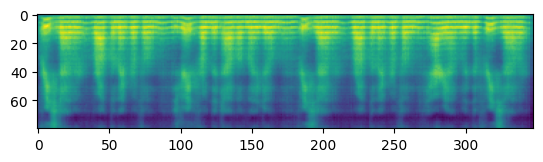

In [221]:
import soundfile as sf

def create_str(shift_pch, scale_dur):
    if scale_dur == 0.5:
        dur_str = "_half_dur"
    elif scale_dur == 2:
        dur_str = "_double_dur"
    elif scale_dur == 1.0:
        dur_str = ""
    else:
        dur_str = f"_{str(scale_dur)}_dur"
    pitch_str = f"_{abs(shift_pch)}hz_{'up' if shift_pch > 0 else 'down'}"
    if shift_pch == 0:
        pitch_str = ""
    return f"prediction{pitch_str}{dur_str}"

def forward_batch(shift_pch, scale_dur):
    batch = FastPitchBatch(
        texts=symbols_ids.unsqueeze(0),
        text_lengths=lengths,
        pitches=shift_pitch(pitch_pred, shift=shift_pch),
        durations=scale_durations(dur_pred, scale_factor=scale_dur)
    ).to(device)

    with torch.no_grad():
        mels, mel_lens, *_ = fp(batch, use_gt_durations=True, use_gt_pitch=True)
        mels = mels.permute(0, 2, 1)
        audio = hfg(mels)

    mels = mels.squeeze().detach().cpu().numpy()
    audio = audio.squeeze().detach().cpu().numpy()
    return mels, audio, create_str(shift_pch, scale_dur)


shift_pch = -100
scale_dur = 0.4

mels, audio, pth = forward_batch(shift_pch, scale_dur)
sf.write(f"examples/{pth}.wav", audio, 22050)
Ipd.display(Ipd.Audio(audio, rate=22050))
plt.imshow(mels)
plt.show()